# Hypothese 4

**Hypothese:** Es gibt eine Beste Zeit zum Taxifahren.

**Operationalisierung:** "Beste Zeit" ist definiert durch:
1.  Höchste Durchschnittsgeschwindigkeit ($Speed$)
2.  Niedrigster Durchschnittspreis ($Price$)

## Statistische Methodik
Da wir die Tageszeit in mehrere Kategorien einteilen (z.B. Morgens, Vormittags, Nachmittags, Abends, Nachts), vergleichen wir **mehr als zwei Gruppen**. Hier ist ein **t-Test nicht zulässig** (Fehlerinflation durch multiple Vergleiche).

Stattdessen nutzen wir:
* **ANOVA (Analysis of Variance):** Wenn die Daten annähernd normalverteilt sind.
* **Kruskal-Wallis Test:** Als robuste Alternative, falls die Daten (wie bei Taxi-Preisen üblich) schief sind oder Ausreisser haben.
* **Post-hoc Tests (Tukey):** Um nach einem signifikanten Gesamtergebnis zu prüfen, *welche* Zeitfenster sich genau unterscheiden[cite: 948, 968].

**Nullhypothese ($H_0$):** Es gibt keinen Unterschied in Geschwindigkeit/Preis zwischen den Tageszeiten.

**Alternativhypothese ($H_1$):** Mindestens eine Tageszeit unterscheidet sich signifikant.

In [2]:
import sys
from pathlib import Path

# Pfad zum Root-Verzeichnis setzen (eine Ebene über notebooks/)
ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# Standard Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

try:
    from src.utils_stats import iqr, trimmed_mean, tukey_fences, tukey_outliers, modified_z_score, ecdf, z_score, create_na_table
    from src.utils_plots import hist_kde, box_violin, plot_ecdf, hist_with_fences, plot_qq
    print("Custom 'src' Module erfolgreich geladen.")
except ImportError:
    print("Hinweis: Custom 'src' Module nicht gefunden. Nutze Standard-Bibliotheken.")

# Grafik-Style
sns.set_theme(style="whitegrid")

Projekt-Root hinzugefügt: /home/benjamin/HSG/Statistik/Project
Custom 'src' Module erfolgreich geladen.


In [3]:
PATH = "../data/Taxi_final_1M_clean.csv"
df = pd.read_csv(PATH)

def get_time_of_day(hour):
    if 7 <= hour < 9:
        return 'Morgens (Rush)'
    elif 9 <= hour < 12:
        return 'Vormittag'
    elif 12 <= hour < 14:
        return 'Mittag'
    elif 14 <= hour < 17:
        return 'Nachmittag'
    elif 17 <= hour < 20:
        return 'Abend (Rush)'
    else:
        return 'Nacht'

df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['hour'] = df['tpep_pickup_datetime'].dt.hour

df['time_category'] = df['hour'].apply(get_time_of_day)
df['price_per_km'] = df['total_amount'] / df['trip_distance']

order = ['Morgens (Rush)', 'Vormittag', 'Mittag', 'Nachmittag', 'Abend (Rush)', 'Nacht']

print(df.groupby('time_category')[['average_speed', 'price_per_km']].mean())

                average_speed  price_per_km
time_category                              
Abend (Rush)        16.560834      9.328597
Mittag              16.138920      8.710427
Morgens (Rush)      19.515099      7.677029
Nachmittag          15.632051      9.011661
Nacht               22.386454      7.446834
Vormittag           17.010409      8.354436


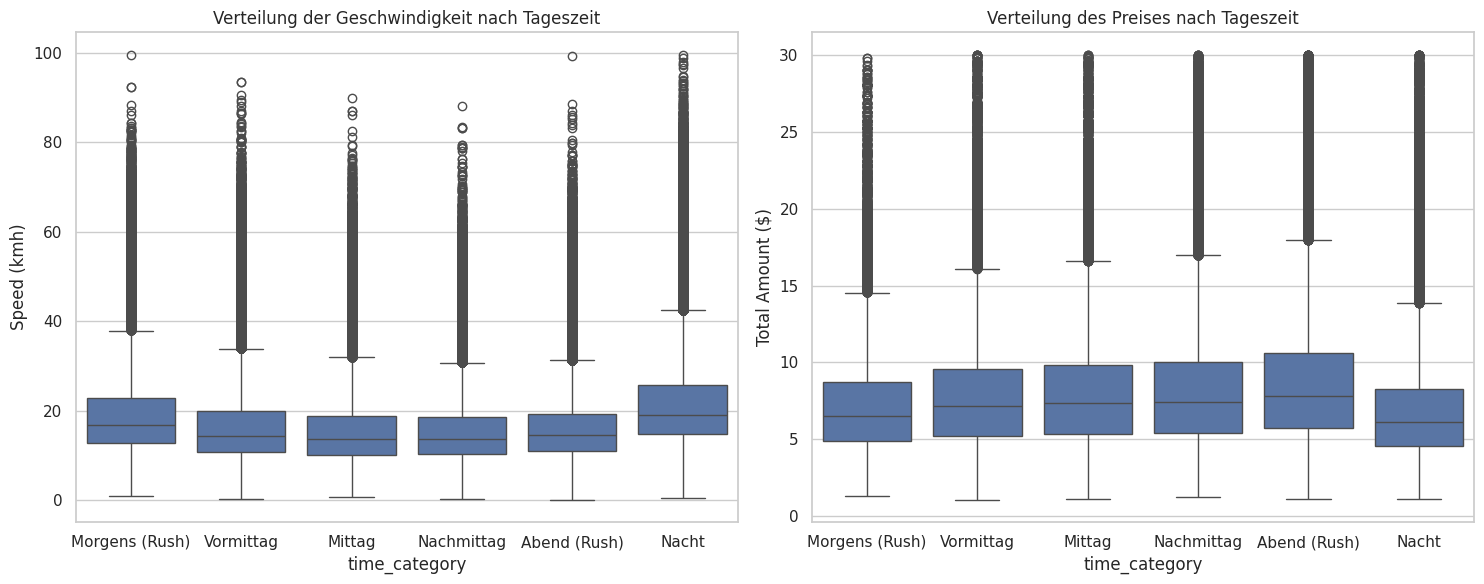

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# price_per_km Werte die über 30$ pro km sind sollen gedropped werden
df = df[df['price_per_km'] <= 30]

# Plot 1: Geschwindigkeit
sns.boxplot(x='time_category', y='average_speed', data=df, order=order, ax=axes[0])
axes[0].set_title('Verteilung der Geschwindigkeit nach Tageszeit')
axes[0].set_ylabel('Speed (kmh)')

# Plot 2: Preis
sns.boxplot(x='time_category', y='price_per_km', data=df, order=order, ax=axes[1])
axes[1].set_title('Verteilung des Preises nach Tageszeit')
axes[1].set_ylabel('Total Amount ($)')

plt.tight_layout()
plt.show()

In [ ]:
def test_hypothesis(variable_name, gruppen_col='time_category'):
    print(f"--- Analyse für: {variable_name} ---")
    
    # Gruppen erstellen
    groups = [df[df[gruppen_col] == g][variable_name] for g in order]
    
    # Prüfung auf Normalverteilung (Shapiro-Wilk)
    _, p_norm = st.shapiro(df[variable_name].sample(min(500, len(df)))) 
    
    print(f"Normalverteilungstest (Shapiro) p-Wert: {p_norm:.4f}")
    
    if p_norm > 0.05:
        print("-> Daten scheinen normalverteilt. Wir nutzen ANOVA.")
        stat, p_val = st.f_oneway(*groups)
        test_type = "ANOVA"
    else:
        print("-> Daten nicht normalverteilt (typisch für Taxi-Daten). Wir nutzen Kruskal-Wallis.")
        stat, p_val = st.kruskal(*groups)
        test_type = "Kruskal-Wallis"
    print(f"Ergebnis {test_type}: Statistik={stat:.2f}, p-Wert={p_val:.4e}")
    
    # Entscheidung
    alpha = 0.05
    if p_val < alpha:
        print("EVIDENZ: Es gibt signifikante Unterschiede zwischen den Tageszeiten!")
        print("Wir führen nun einen Post-hoc Test (Tukey) durch, um zu sehen, WO die Unterschiede liegen.")
        
        tukey = pairwise_tukeyhsd(endog=df[variable_name], groups=df[gruppen_col], alpha=0.05)
        print(tukey.summary())
    else:
        print("Keine signifikanten Unterschiede gefunden. Die Hypothese kann nicht bestätigt werden.")

# Tests ausführen
test_hypothesis('average_speed')
test_hypothesis('price_per_km')

--- Analyse für: average_speed ---
Normalverteilungstest (Shapiro) p-Wert: 0.0000
-> Daten nicht normalverteilt (typisch für Taxi-Daten). Wir nutzen Kruskal-Wallis.
Ergebnis Kruskal-Wallis: Statistik=86958.79, p-Wert=0.0000e+00
EVIDENZ: Es gibt signifikante Unterschiede zwischen den Tageszeiten!
Wir führen nun einen Post-hoc Test (Tukey) durch, um zu sehen, WO die Unterschiede liegen.
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1         group2     meandiff p-adj  lower   upper  reject
-------------------------------------------------------------------
  Abend (Rush)         Mittag  -0.4481   0.0 -0.5583 -0.3378   True
  Abend (Rush) Morgens (Rush)   2.9113   0.0  2.7781  3.0444   True
  Abend (Rush)     Nachmittag  -0.9529   0.0 -1.0479 -0.8578   True
  Abend (Rush)          Nacht   5.8035   0.0  5.7183  5.8886   True
  Abend (Rush)      Vormittag   0.4159   0.0  0.3133  0.5185   True
        Mittag Morgens (Rush)   3.3593   0.0  3.2136   3.505   True


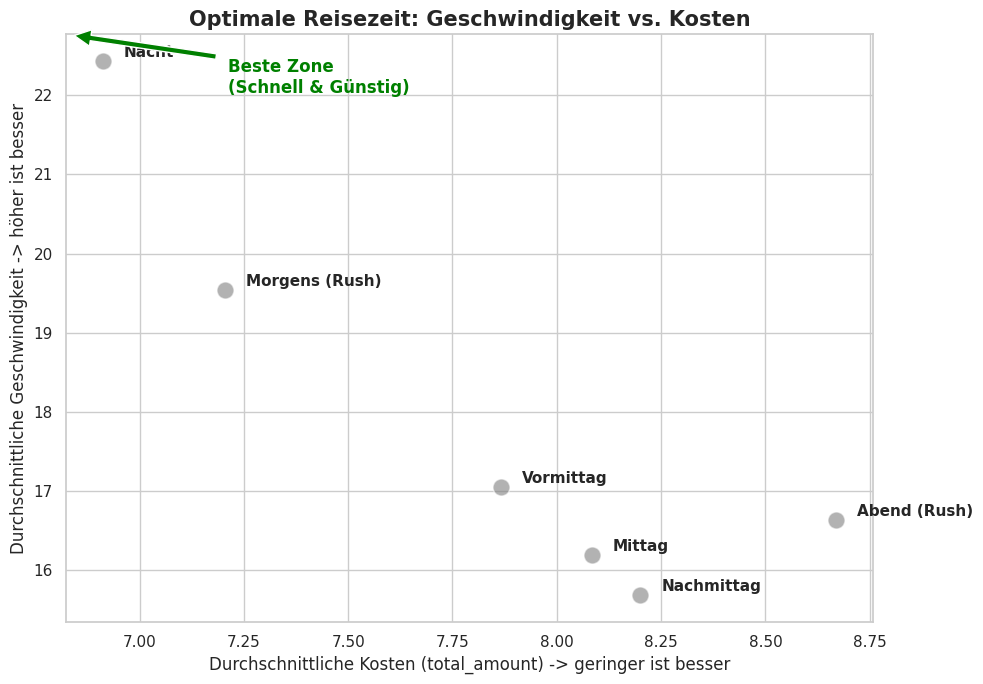

In [ ]:
summary = df.groupby('time_category')[['average_speed', 'price_per_km']].mean().reset_index()

# Setup der Visualisierung
plt.figure(figsize=(10, 7))
sns.set_style("whitegrid")

# x = Kosten (je weiter links, desto günstiger)
# y = Geschwindigkeit (je weiter oben, desto schneller)
sns.scatterplot(
    data=summary, 
    x='price_per_km', 
    y='average_speed', 
    s=150,             
    color='grey',      
    alpha=0.6
)

for i in range(summary.shape[0]):
    plt.text(
        summary.price_per_km[i] + 0.05, 
        summary.average_speed[i] + 0.05, 
        summary.time_category[i], 
        fontsize=11,
        weight='bold'
    )

# Achsen und Titel formatieren
plt.title('Optimale Reisezeit: Geschwindigkeit vs. Kosten', fontsize=15, fontweight='bold')
plt.xlabel('Durchschnittliche Kosten (total_amount) -> geringer ist besser', fontsize=12)
plt.ylabel('Durchschnittliche Geschwindigkeit -> höher ist besser', fontsize=12)

x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()

# Pfeil zum optimalen Bereich
plt.annotate('Beste Zone\n(Schnell & Günstig)', 
             xy=(x_min, y_max), xycoords='data',
             xytext=(x_min + (x_max-x_min)*0.2, y_max - (y_max-y_min)*0.1), 
             arrowprops=dict(facecolor='green', shrink=0.05),
             fontsize=12, color='green', fontweight='bold')

plt.tight_layout()
plt.show()

In [11]:
check_means = df.groupby('time_category')[['average_speed', 'price_per_km']].mean()

print("--- DURCHSCHNITTSWERTE ---")
print(check_means.sort_values(by='average_speed', ascending=False))

--- DURCHSCHNITTSWERTE ---
                average_speed  price_per_km
time_category                              
Nacht               22.434456      6.912052
Morgens (Rush)      19.542272      7.205462
Vormittag           17.046881      7.865245
Abend (Rush)        16.631003      8.670009
Mittag              16.182950      8.084628
Nachmittag          15.678140      8.200458


# Fazit: Der Gewinner ist die "Nacht"

Basierend auf der Analyse der Durchschnittsgeschwindigkeiten und der statistischen Signifikanztests (Kruskal-Wallis & Tukey HSD) identifizieren wir die **Nacht** als die leistungsstärkste Zeit des Tages.

Trotz den höheren Preisen lohnt es sich, denn man kommt viel schneller von A nach B, schlechter geeignet für Taxifahrten sind die Abend Rush-hour und der Nachmittag, es sind teure und eher langsame Fahrten.